In [ ]:
!pip install MiniSom
!pip install tslearn

In [ ]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

SEASONAL DATA

In [ ]:
import os
import pandas as pd
import random

directory = 'data/'
desired_years = [2012, 2013]
all_months = list(range(1, 13))

season_months = {
    "spring": [3, 4, 5],
    "summer": [6, 7, 8],
    "autumn": [9, 10, 11],
    "winter": [12, 1, 2]
}

def filter_complete_years(df):
    years_present = df.index.year.unique()
    return all(year in years_present for year in desired_years)
def filter_complete_months(df):
    complete_months = []
    for year in desired_years:
        for season in all_months:
            if df[(df.index.year == year) & (df.index.season == season)].empty:
                complete_months.append(False)
            else:
                complete_months.append(True)
    return all(complete_months)

mySeries = []
namesofMySeries = []

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(directory + filename)
        df = df.loc[:, ["time", "energy_sum"]]
        df["time"] = pd.to_datetime(df["time"])
        df.set_index("time", inplace=True)
        df.sort_index(inplace=True)

        df = df[df.index.year.isin(desired_years)]

        if not df.empty and filter_complete_years(df) and filter_complete_months(df):  # Check for complete years
            mySeries.append(df)
            namesofMySeries.append(filename[:-4])

print(len(mySeries))
# Randomly select 60 names from namesofMySeries
random_names = random.sample(namesofMySeries, 50)

print(random_names)

181
['MAC000232', 'MAC000245', 'MAC004457', 'MAC000235', 'MAC004478', 'MAC000049', 'MAC000035', 'MAC004849', 'MAC000057', 'MAC000132', 'MAC000089', 'MAC000115', 'MAC004943', 'MAC000042', 'MAC004979', 'MAC000238', 'MAC004999', 'MAC000175', 'MAC004492', 'MAC004553', 'MAC005038', 'MAC004998', 'MAC004936', 'MAC000210', 'MAC004551', 'MAC000129', 'MAC004581', 'MAC005001', 'MAC000226', 'MAC004584', 'MAC000092', 'MAC004944', 'MAC004508', 'MAC000242', 'MAC000066', 'MAC004562', 'MAC004456', 'MAC004946', 'MAC000053', 'MAC004889', 'MAC000055', 'MAC000045', 'MAC004521', 'MAC000222', 'MAC004894', 'MAC005022', 'MAC005016', 'MAC000019', 'MAC004552', 'MAC000107']


MONTHLY DATA

In [ ]:
import os
import pandas as pd

directory = 'data/'
desired_year = 2012  # year to be read
desired_month = [6]  # month to be read

desired_houses = random_names
mySeries = []
namesofMySeries = []

for filename in desired_houses:
    file_path = os.path.join(directory, filename)
    file_path = file_path + ".csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df = df.loc[:, ["time", "energy_sum"]]
        df["time"] = pd.to_datetime(df["time"])
        df.set_index("time", inplace=True)
        df.sort_index(inplace=True)

        df = df[(df.index.year == desired_year) & (df.index.month.isin(desired_month))]

        if not df.empty:
            mySeries.append(df)
            namesofMySeries.append(filename[:-4])
    else:
        print(f"File not found: {file_path}")

In [ ]:
len(mySeries)

50

In [ ]:
fig, axs = plt.subplots(6,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(6):
    for j in range(4):
        if i*4+j+1>len(mySeries):
            continue
        axs[i, j].plot(mySeries[i*4+j].values)
        axs[i, j].set_title(namesofMySeries[i*4+j])
plt.show()


In [ ]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{31}


In [ ]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{29, 30}


In [ ]:
max_len = max(series_lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

In [ ]:
problems_index = []

for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)

In [ ]:
import numpy as np

max_len = len(longest_series)

for i in range(len(mySeries)):
    if len(mySeries[i]) < max_len:
        num_missing = max_len - len(mySeries[i])
        missing_data = np.full(num_missing, np.nan)
        mySeries[i] = np.concatenate((mySeries[i], missing_data))


In [ ]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = scaler.fit_transform(mySeries[i].reshape(-1, 1)).reshape(-1)


In [ ]:
som_x = 8
som_y = 2

som = MiniSom(som_x, som_y,len(mySeries[0]), sigma= 1.5, learning_rate = 0.01)

som.random_weights_init(mySeries)
som.train(mySeries, 500000)

In [ ]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="blue",alpha=0.5)
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="orange")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [ ]:
win_map = som.win_map(mySeries)
plot_som_series_averaged_center(som_x, som_y, win_map)

In [ ]:
# i = 0

for x in range(som_x):
  for y in range(som_y):
    cluster = (x,y)
    if cluster in win_map.keys():

      winmaps.append(np.average(np.vstack(win_map[cluster]),axis=0))


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

data = winmaps
data_array = np.array(data)

imputer = SimpleImputer(strategy='mean')
data_array_cleaned = imputer.fit_transform(data_array)

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data_array_cleaned)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FINIDNG THE OPTIMUM NUMBER OF CLUSTERS

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

data = winmaps
data_array = np.array(data)
imputer = SimpleImputer(strategy='mean')
data_array_cleaned = imputer.fit_transform(data_array)

# Choose a range of clusters to search over
param_grid = {'n_clusters': [2, 3, 4, 5, 6]}
kmeans = KMeans()
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, scoring='neg_median_absolute_error', cv=5)
grid_search.fit(data_array_cleaned)
best_clusters = grid_search.best_params_['n_clusters']
best_score = -grid_search.best_score_

print(f"Best Number of Clusters: {best_clusters}")
print(f"Best Silhouette Score: {best_score}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn

Best Number of Clusters: 2
Best Silhouette Score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-pac

padding

In [ ]:
data = winmaps

max_length = max(len(arr) for arr in data)
for i, arr in enumerate(data):
    if len(arr) < max_length:
        data[i] = np.pad(arr, (0, max_length - len(arr)))

data_array = np.array(data)

# kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

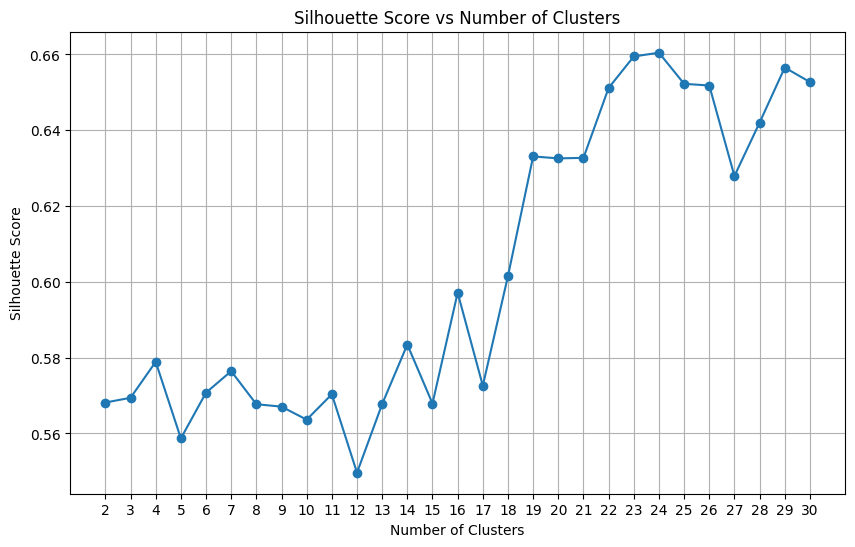

Best Silhouette Score: 0.6604618005897627
Number of Clusters with Best Silhouette Score: 24


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


data_array = np.array(data)

imputer = SimpleImputer(strategy='mean')
data_array_cleaned = imputer.fit_transform(data_array)

num_components = 1
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(data_array_cleaned)


min_clusters = 2
max_clusters = 30
best_silhouette_score = -1
best_num_clusters = 0
silhouette_scores = []

for num_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(reduced_data)
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = num_clusters

plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Number of Clusters with Best Silhouette Score: {best_num_clusters}")


CLUSTERS

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

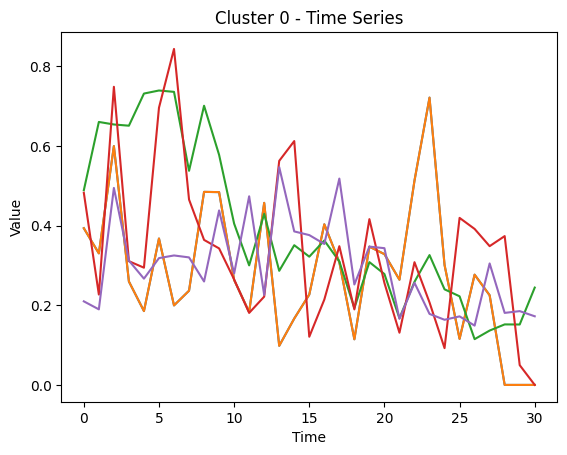

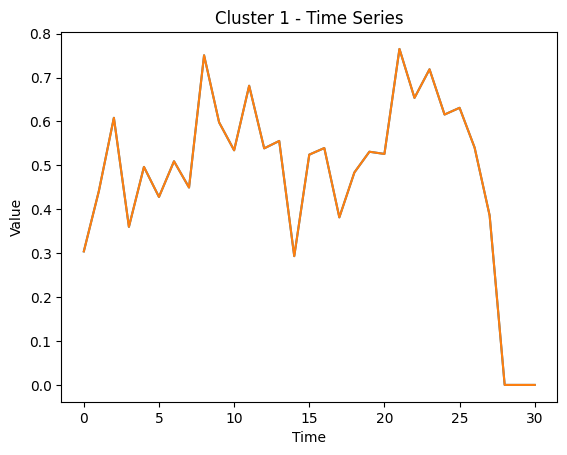

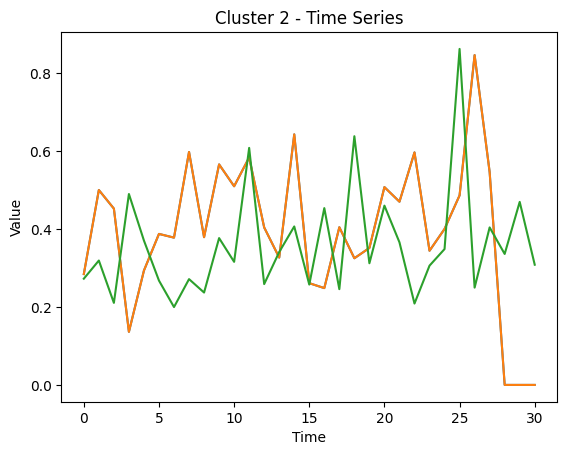

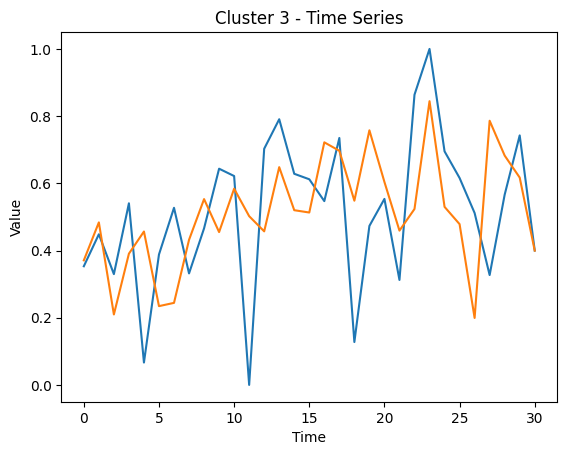

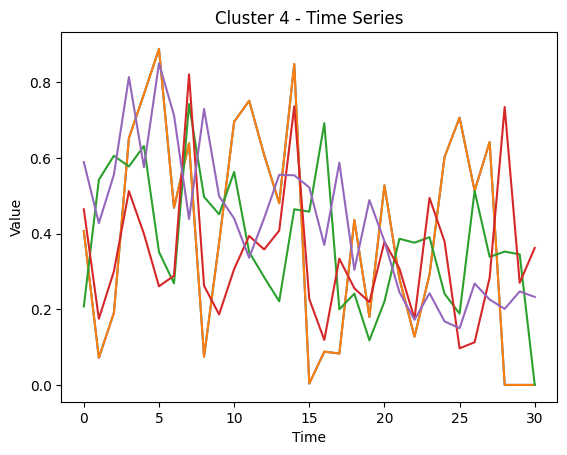

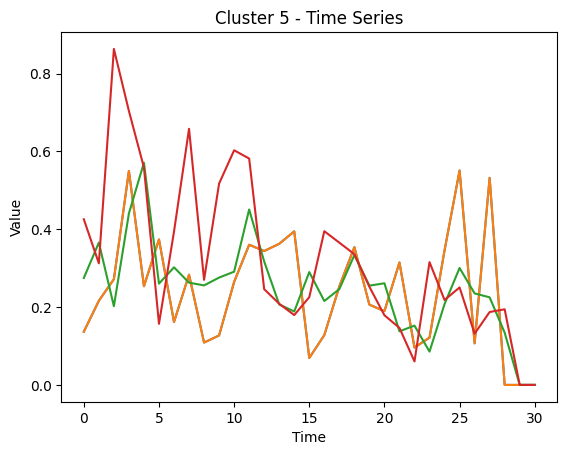

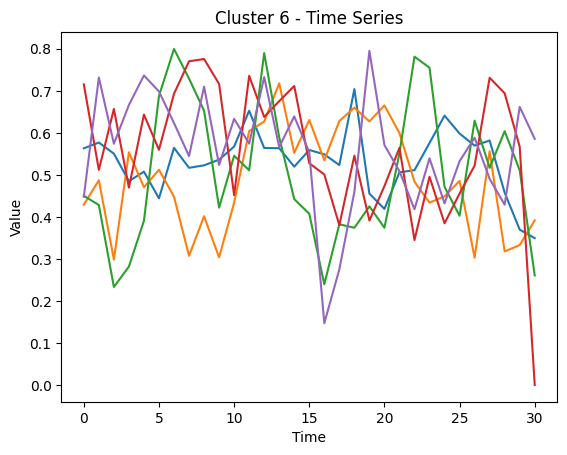

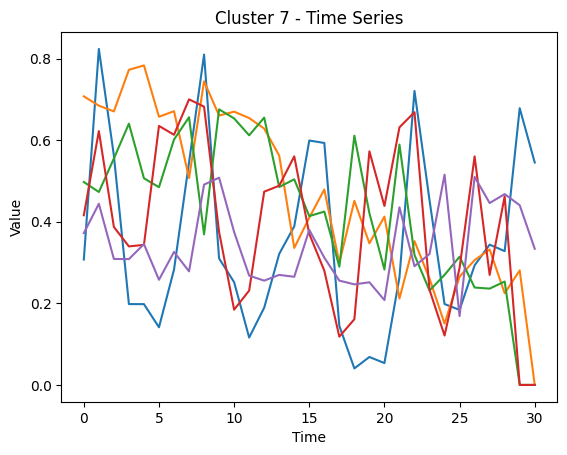

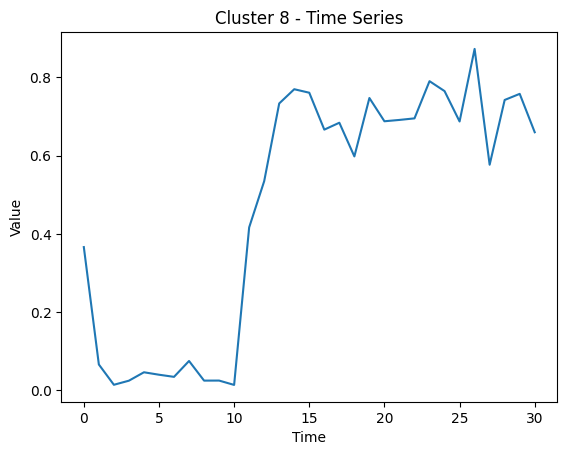

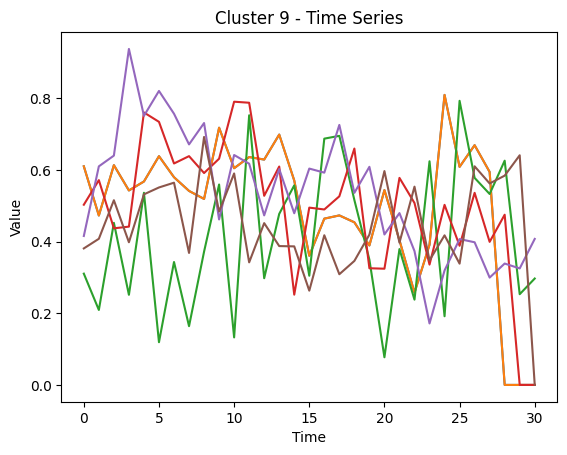

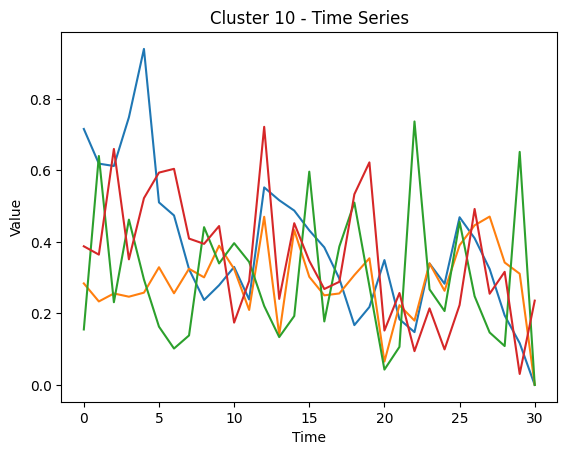

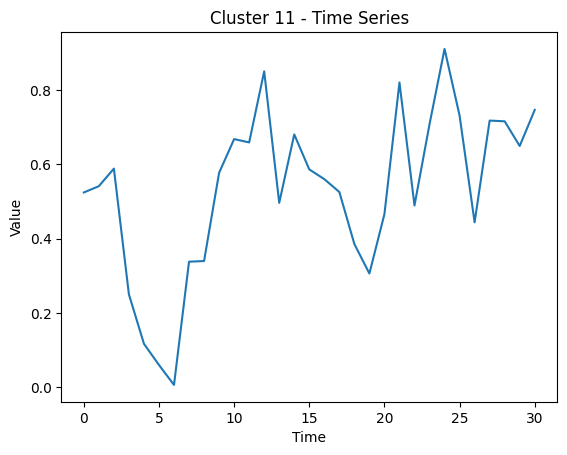

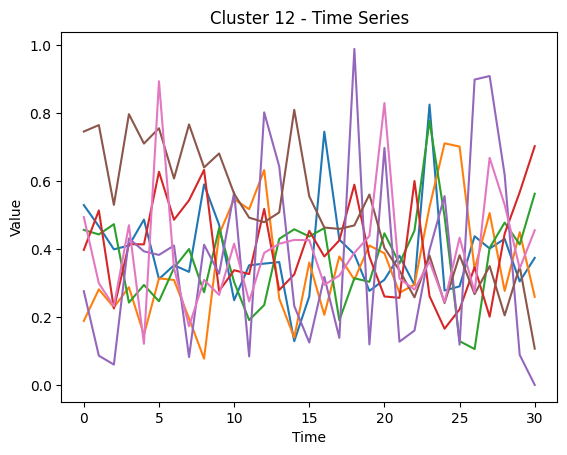

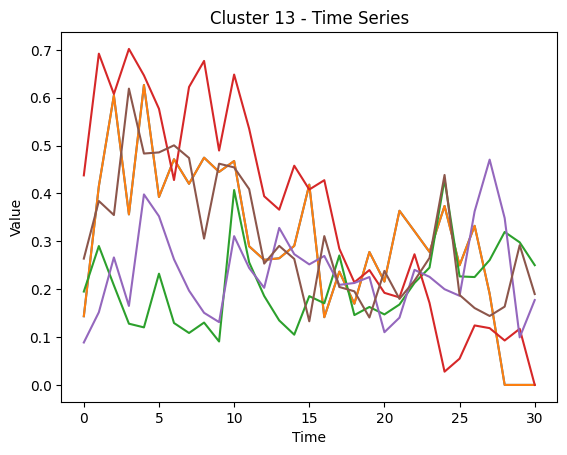

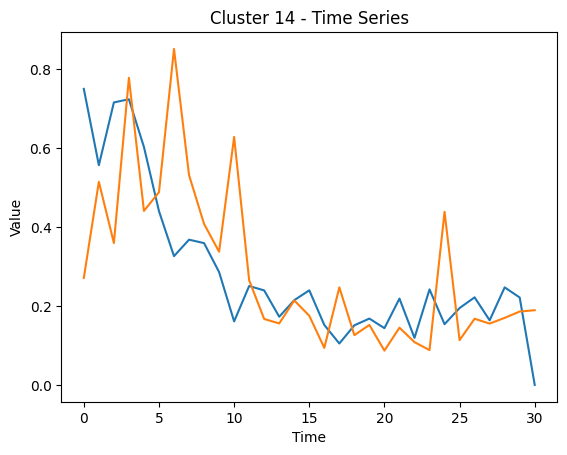

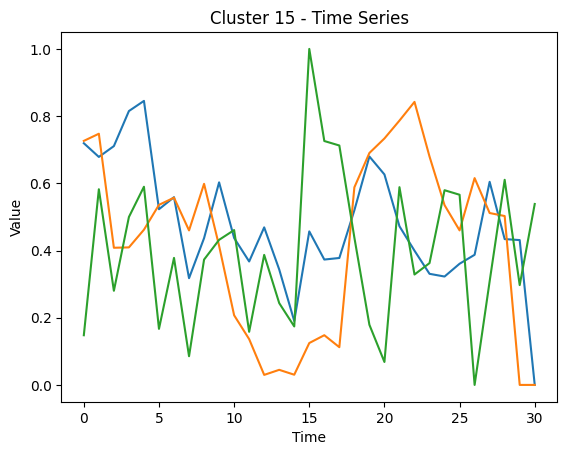

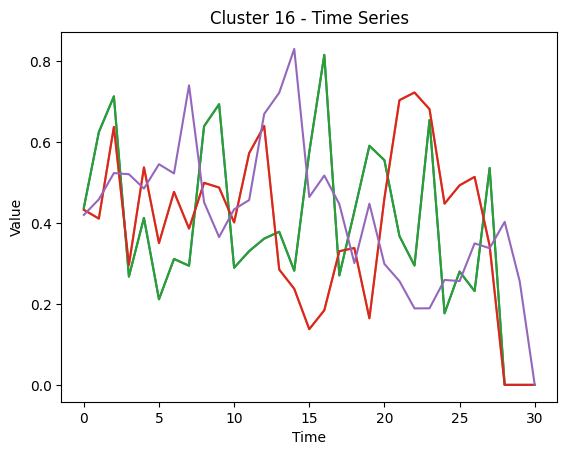

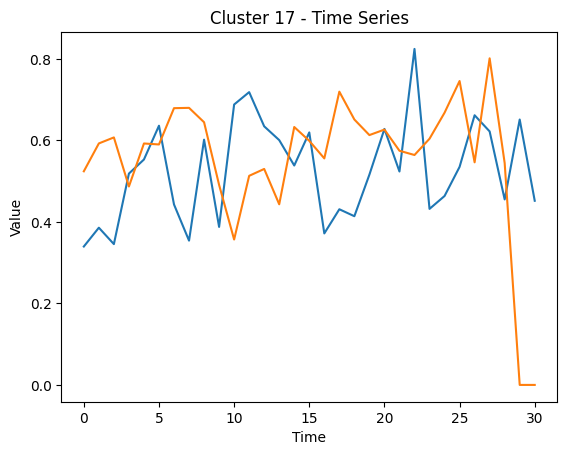

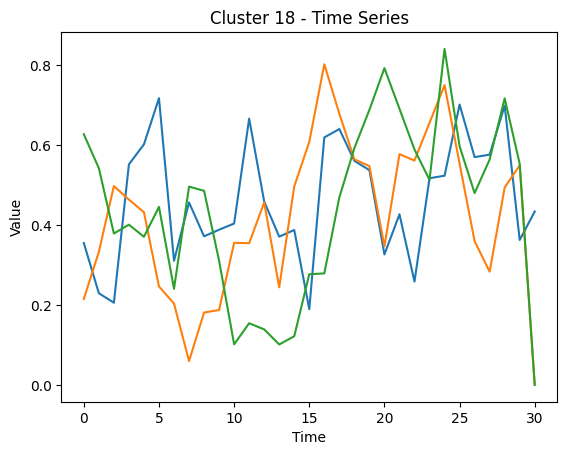

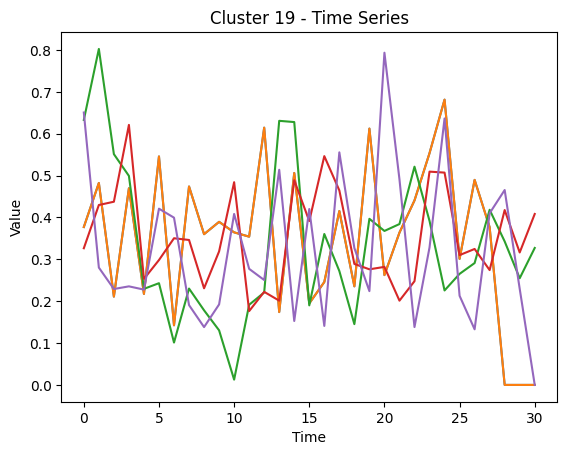

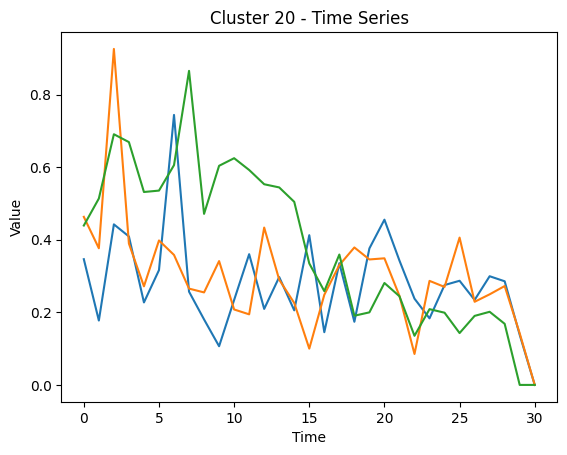

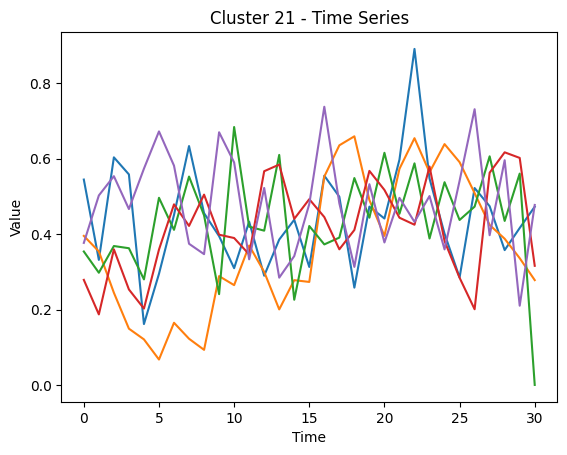

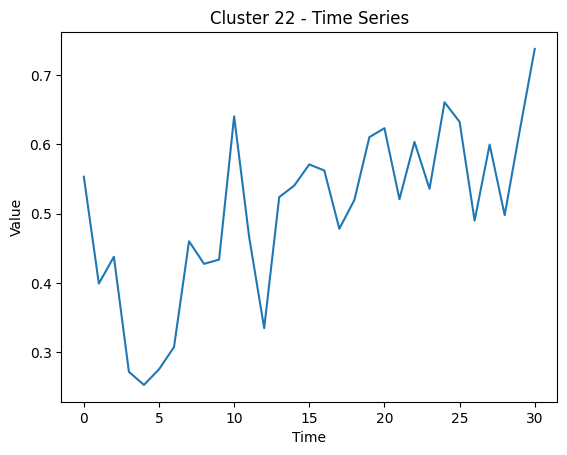

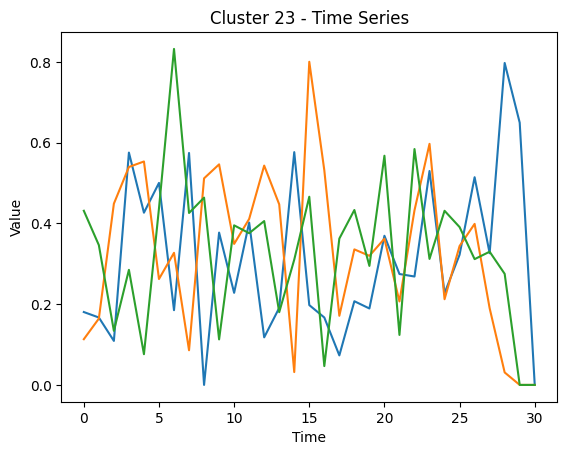

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


data_array = np.array(data)

imputer = SimpleImputer(strategy='mean')
data_array_cleaned = imputer.fit_transform(data_array)

num_components = 1
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(data_array_cleaned)
num_clusters = 24
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(reduced_data)
cluster_labels = kmeans.labels_
plt.figure(figsize=(20, 10))

for cluster_id in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    plt.figure()
    for idx in cluster_indices:
        plt.plot(data_array[idx])

    plt.title(f'Cluster {cluster_id} - Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

SOM Average of Cluster Patterns

In [ ]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                # for series in win_map[cluster]:
                    # axs[cluster].plot(series,c="blue",alpha=0.5)
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

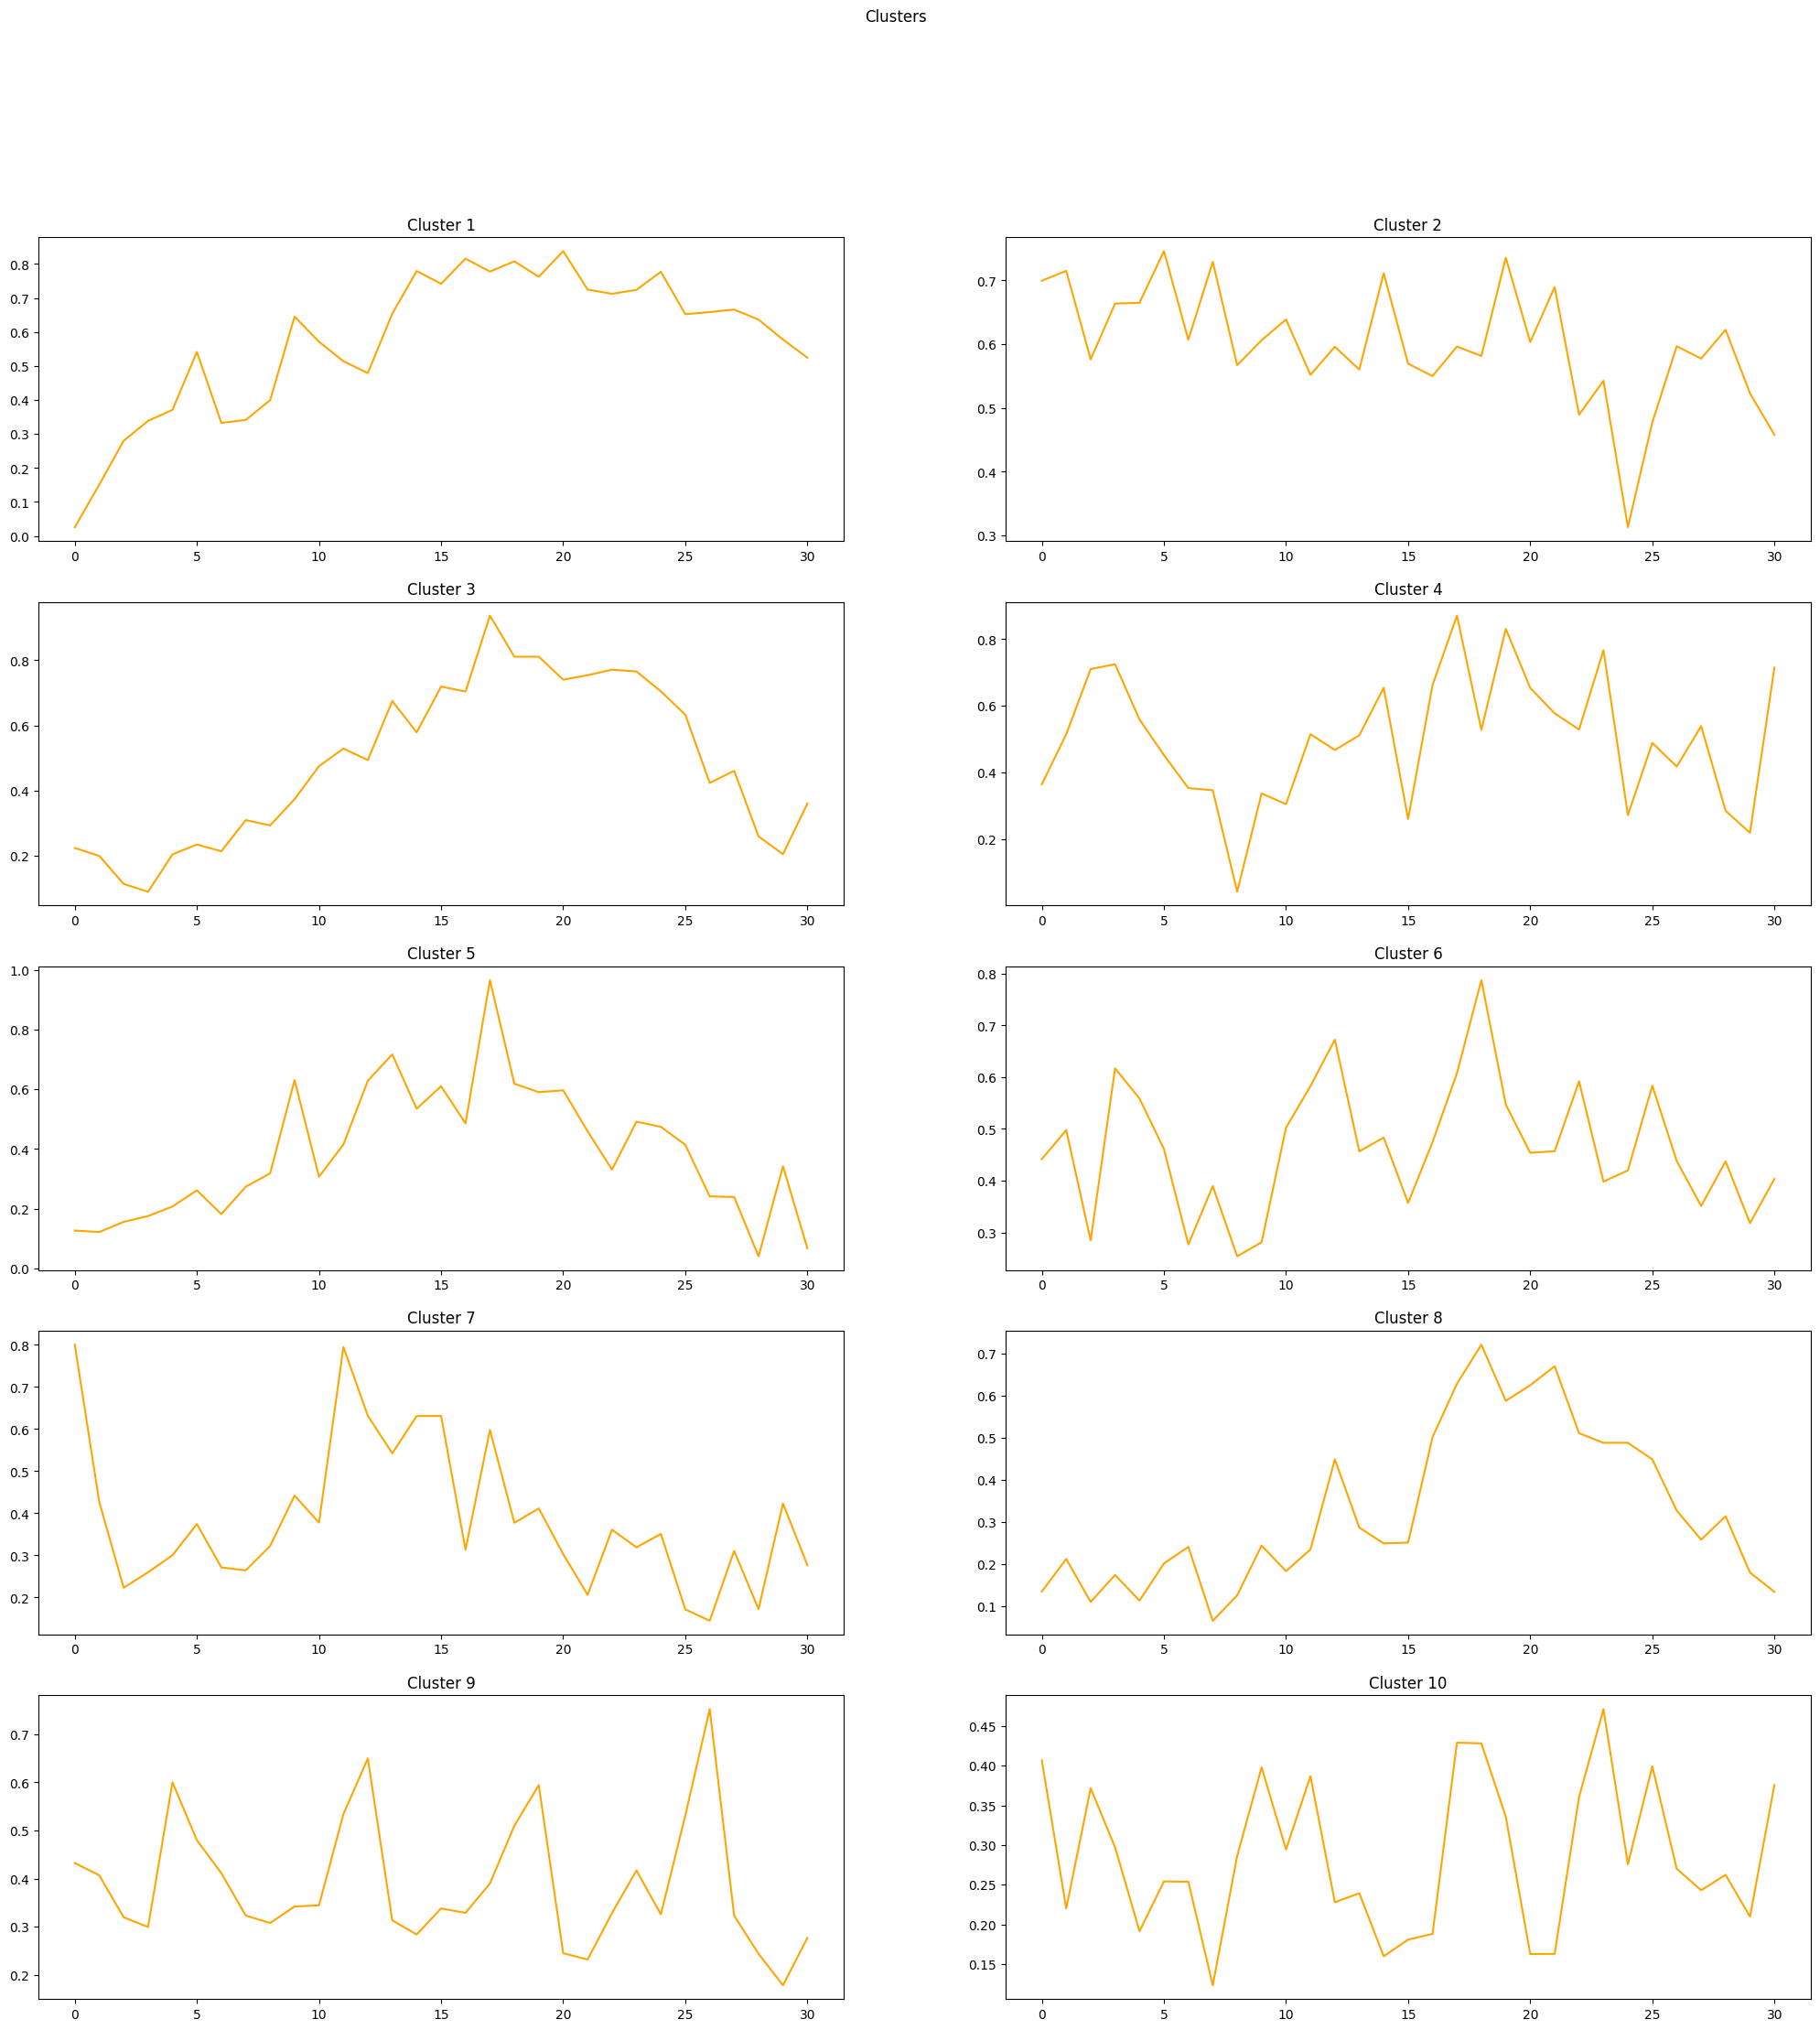

In [ ]:
win_map = som.win_map(mySeries)
plot_som_series_averaged_center(som_x, som_y, win_map)

finding the houses in each cluster

In [ ]:
cluster_assignments = np.empty(len(mySeries), dtype=int)

for i, data_point in enumerate(mySeries):
    bmu = som.winner(data_point)
    cluster_assignments[i] = bmu[0] * som_x + bmu[1]

house_clusters = {}

for i, cluster_idx in enumerate(cluster_assignments):
    house_name = namesofMySeries[i]
    if cluster_idx not in house_clusters:
        house_clusters[cluster_idx] = []
    house_clusters[cluster_idx].append(house_name)

for cluster_idx, house_names in house_clusters.items():
    print(f"Cluster {cluster_idx}: {', '.join(house_names)}")

Cluster 5: MAC001915, MAC001944, MAC001986, MAC002010, MAC002033
Cluster 16: MAC001925, MAC002009, MAC002030, MAC002038, MAC002084, MAC002089
Cluster 20: MAC001932, MAC001945, MAC001996, MAC002034, MAC002077, MAC002079, MAC002127
Cluster 0: MAC001939, MAC001975, MAC002003, MAC002056, MAC002076, MAC002101, MAC002107
Cluster 10: MAC001951, MAC002028, MAC002035, MAC002036, MAC002045, MAC002053, MAC002061, MAC002063, MAC002116
Cluster 1: MAC001981, MAC001997, MAC002023, MAC002024, MAC002044, MAC002122, MAC002129
Cluster 15: MAC001991, MAC002001, MAC002088, MAC002090
Cluster 11: MAC002013, MAC002014, MAC002086, MAC002097
Cluster 21: MAC002022, MAC002050, MAC002055, MAC002094, MAC002124, MAC002128, MAC002137, MAC002139
Cluster 6: MAC002041, MAC002054
